<a href="https://colab.research.google.com/github/ludoveltz/BOOK_IA/blob/main/Assistant_IA__modelisation_formes_simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install trimesh numpy torch transformers matplotlib

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Erreur: No boolean backend: `pip install manifold3d` or install `blender`


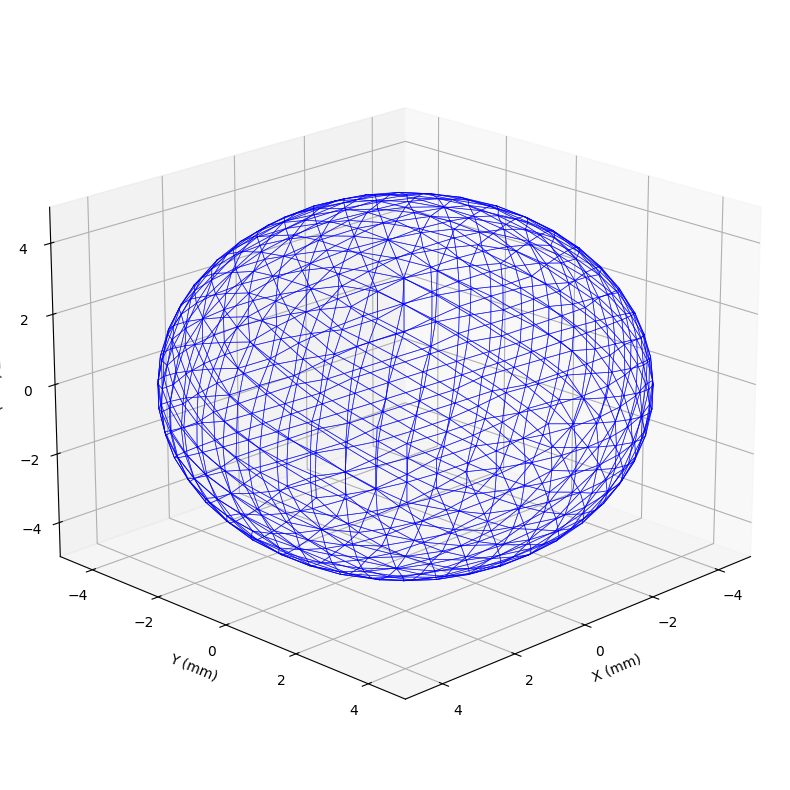

Forme sauvegardée dans forme_generee.stl


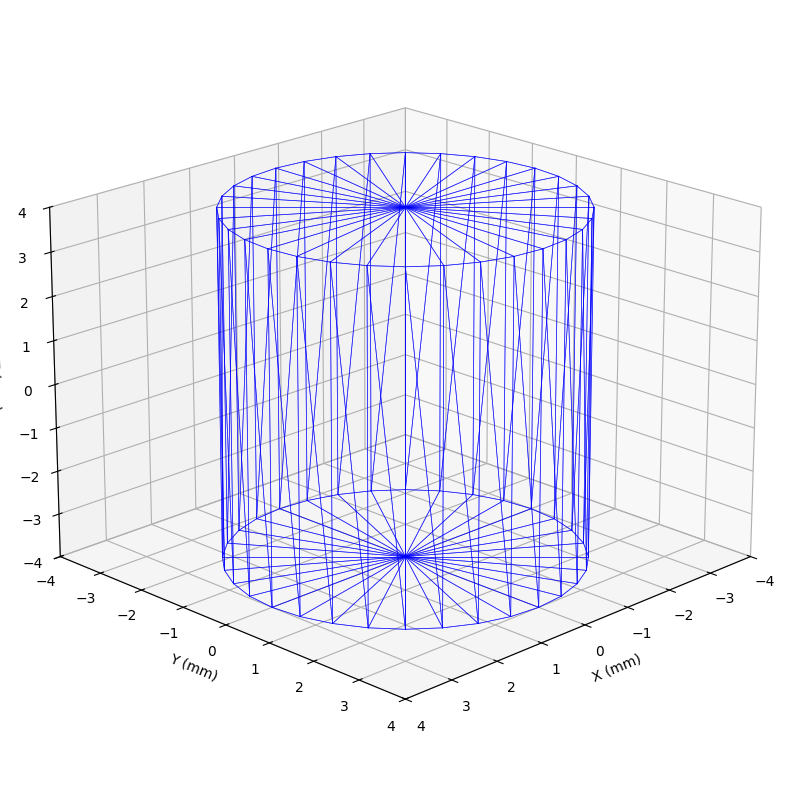

Forme sauvegardée dans forme_generee.stl


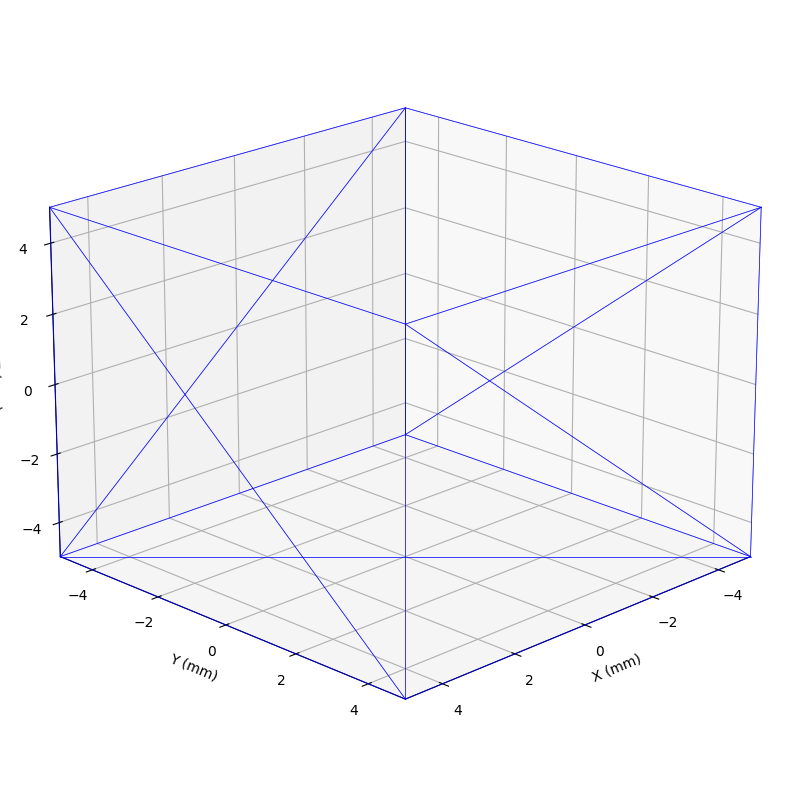

Forme sauvegardée dans forme_generee.stl


In [4]:
# Première cellule : Installation des dépendances
!pip install trimesh numpy torch transformers matplotlib

# Deuxième cellule : Code principal sans Streamlit
import trimesh
import numpy as np
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

class ShapeAssistant:
    def __init__(self):
        self.nlp = pipeline("text-classification", model="bert-base-multilingual-cased")

    def parse_dimensions(self, text):
        import re
        dim_pattern = r'(\d+(?:\.\d+)?)\s*(?:cm|mm|m)?'
        dimensions = re.findall(dim_pattern, text)
        return [float(d) for d in dimensions]

    def create_box(self, dims, hole=None):
        if len(dims) < 3:
            dims = [dims[0]] * 3

        box = trimesh.creation.box(extents=dims)

        if hole and hole > 0:
            cylinder = trimesh.creation.cylinder(
                radius=hole/2,
                height=max(dims) + 1,
                sections=32
            )
            cylinder.vertices += np.array([dims[0]/2, dims[1]/2, 0])
            box = trimesh.boolean.difference([box, cylinder])

        return box

    def create_sphere(self, radius):
        return trimesh.creation.icosphere(radius=radius)

    def create_cylinder(self, radius, height):
        return trimesh.creation.cylinder(radius=radius, height=height)

    def visualize_mesh(self, mesh):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        vertices = mesh.vertices
        faces = mesh.faces

        for face in faces:
            pts = vertices[face]
            for i in range(3):
                start = pts[i]
                end = pts[(i+1)%3]
                ax.plot([start[0], end[0]],
                       [start[1], end[1]],
                       [start[2], end[2]],
                       'b-', linewidth=0.5, alpha=0.7)

        ranges = [np.max(vertices[:,i]) - np.min(vertices[:,i]) for i in range(3)]
        max_range = max(ranges) / 2.0
        mid_x = (np.max(vertices[:,0]) + np.min(vertices[:,0])) * 0.5
        mid_y = (np.max(vertices[:,1]) + np.min(vertices[:,1])) * 0.5
        mid_z = (np.max(vertices[:,2]) + np.min(vertices[:,2])) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')

        ax.view_init(elev=20, azim=45)
        plt.show()

    def process_prompt(self, prompt):
        prompt = prompt.lower()
        dims = self.parse_dimensions(prompt)

        if 'boîte' in prompt or 'cube' in prompt:
            if 'trou' in prompt:
                hole_dims = [d for d in dims if d < max(dims)]
                hole_size = hole_dims[0] if hole_dims else 2.0
                mesh = self.create_box(dims[:3], hole=hole_size)
            else:
                mesh = self.create_box(dims[:3])

        elif 'sphère' in prompt or 'sphere' in prompt:
            mesh = self.create_sphere(dims[0])

        elif 'cylindre' in prompt:
            mesh = self.create_cylinder(dims[0], dims[1])

        else:
            raise ValueError("Type de forme non reconnu")

        return mesh

# Troisième cellule : Interface interactive avec IPython
assistant = ShapeAssistant()

def generate_shape(prompt):
    try:
        mesh = assistant.process_prompt(prompt)
        assistant.visualize_mesh(mesh)

        # Sauvegarder en STL
        filename = "forme_generee.stl"
        mesh.export(filename)
        print(f"Forme sauvegardée dans {filename}")

    except Exception as e:
        print(f"Erreur: {str(e)}")

# Exemple d'utilisation :
prompt = "crée une boîte de 10x10x10cm"
generate_shape("crée une boîte de 10x10x10cm avec un trou de 2cm")
generate_shape("crée une sphère de 5cm de rayon")
generate_shape("crée un cylindre de 3cm de rayon et 8cm de hauteur")


